In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import os
import codecs
import time
import shutil
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import seaborn as sns

In [25]:
!pip install selenium

     ---------------------------------------- 6.3/6.3 MB 3.8 MB/s eta 0:00:00
     ------------------------------------- 384.9/384.9 kB 11.7 MB/s eta 0:00:00
     ---------------------------------------- 58.3/58.3 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Gathering

In [2]:
# Gathering our data for mvp votes

years = list(range(1990,2022))
url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

#Creating the directory to store our html files
if not os.path.exists("mvps htmls"):
    os.makedirs("mvps htmls")
    
for year in years:
    url = url_start.format(year)
    time.sleep(10)
    data = requests.get(url)
    
    with codecs.open("mvps htmls/{}.html".format(year), "w+", encoding="utf-8") as f:
        f.write(data.text)

In [43]:
# Gathering our data for player stats each year
#This time it will be a bit more tricky beacuse the webpage uses javascript to render the rest of the page so we will use selenium
driver = webdriver.Chrome("/path/to/chromedriver")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1848\3154302240.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("/path/to/chromedriver")


In [45]:
player_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"

#Creating the directory to store our html files
if not os.path.exists("Player Stats"):
    os.makedirs("Player Stats")
    
for year in years:
    url = player_stats_url.format(year)
    
    driver.get(url)
    driver.execute_script("window.scrollTo(1,10000)")
    time.sleep(2)
    
    with codecs.open("Player Stats/{}.html".format(year), "w+", encoding="utf-8") as f:
        f.write(driver.page_source)

In [3]:
# Gathering our data for team record for each year
years = list(range(1990,2022))
team_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_standings.html"

#Creating the directory to store our html files
if not os.path.exists("Team Stats"):
    os.makedirs("Team Stats")

for year in years:
    url = team_stats_url.format(year)
    time.sleep(10)
    data = requests.get(url)
    
    with open("Team Stats/{}.html".format(year), "w+", encoding="utf-8") as f:
        f.write(data.text)

In [3]:
#Gathering all the downloaded mvp html files into a list of dataframes
dfs = []
for year in years:
    with open("mvps htmls/{}.html".format(year),encoding="utf-8") as f:
        page = f.read()
    
    soup =bs(page, 'html.parser')
    #The table has an overheader that we do not need so we'll use decompose
    soup.find('tr', class_="over_header").decompose()
    mvp_table = soup.find_all(id="mvp")[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df["Year"] = year
    dfs.append(mvp_df)

In [46]:
dfs2 = []
for year in years:
    with open("Player Stats/{}.html".format(year),encoding="utf-8") as f:
        page = f.read()
    
    soup =bs(page, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    player_table = soup.find_all(id="per_game_stats")[0]
    player_df = pd.read_html(str(player_table))[0]
    player_df["Year"] = year
    dfs2.append(player_df)

In [5]:
dfs3 = []
for year in years:
    with open("Team Stats/{}.html".format(year),encoding="utf-8") as f:
        page = f.read()
    
    soup = bs(page, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    e_table = soup.find_all(id="divs_standings_E")[0]
    e_df = pd.read_html(str(e_table))[0]
    e_df["Year"] = year
    e_df["Team"] = e_df["Eastern Conference"]
    del e_df["Eastern Conference"]
    dfs3.append(e_df)
    
    w_table = soup.find_all(id="divs_standings_W")[0]
    w_df = pd.read_html(str(w_table))[0]
    w_df["Year"] = year
    w_df["Team"] = w_df["Western Conference"]
    del w_df["Western Conference"]
    dfs3.append(w_df)

In [5]:
#Uniting all mvp dataframes into one big data frame
mvps=pd.concat(dfs)
mvps

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Magic Johnson,30,LAL,27.0,636.0,920,0.691,79,37.2,...,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990
1,2,Charles Barkley,26,PHI,38.0,614.0,920,0.667,79,39.1,...,11.5,3.9,1.9,0.6,0.600,0.217,0.749,17.3,0.269,1990
2,3,Michael Jordan,26,CHI,21.0,564.0,920,0.613,82,39.0,...,6.9,6.3,2.8,0.7,0.526,0.376,0.848,19.0,0.285,1990
3,4,Karl Malone,26,UTA,2.0,214.0,920,0.233,82,38.1,...,11.1,2.8,1.5,0.6,0.562,0.372,0.762,15.9,0.245,1990
4,5,Patrick Ewing,27,NYK,1.0,162.0,920,0.176,82,38.6,...,10.9,2.2,1.0,4.0,0.551,0.250,0.775,13.5,0.205,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,11,Russell Westbrook,32,WAS,0.0,5.0,1010,0.005,65,36.4,...,11.5,11.7,1.4,0.4,0.439,0.315,0.656,3.7,0.075,2021
11,12,Ben Simmons,24,PHI,0.0,3.0,1010,0.003,58,32.4,...,7.2,6.9,1.6,0.6,0.557,0.300,0.613,6.0,0.153,2021
12,13T,James Harden,31,TOT,0.0,1.0,1010,0.001,44,36.6,...,7.9,10.8,1.2,0.8,0.466,0.362,0.861,7.0,0.208,2021
13,13T,LeBron James,36,LAL,0.0,1.0,1010,0.001,45,33.4,...,7.7,7.8,1.1,0.6,0.513,0.365,0.698,5.6,0.179,2021


In [6]:
#Storing our dataframe into a csv file 
mvps.to_csv("mvps.csv")

In [7]:
mvps_df = pd.read_csv(r'C:\Users\ADMIN\Documents\School\שנה ב\Project\mvps.csv')
mvps_df

,Unnamed: 0,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,0,1,Magic Johnson,30,LAL,27.0,636.0,920,0.691,79,...,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990
1,1,2,Charles Barkley,26,PHI,38.0,614.0,920,0.667,79,...,11.5,3.9,1.9,0.6,0.600,0.217,0.749,17.3,0.269,1990
2,2,3,Michael Jordan,26,CHI,21.0,564.0,920,0.613,82,...,6.9,6.3,2.8,0.7,0.526,0.376,0.848,19.0,0.285,1990
3,3,4,Karl Malone,26,UTA,2.0,214.0,920,0.233,82,...,11.1,2.8,1.5,0.6,0.562,0.372,0.762,15.9,0.245,1990
4,4,5,Patrick Ewing,27,NYK,1.0,162.0,920,0.176,82,...,10.9,2.2,1.0,4.0,0.551,0.250,0.775,13.5,0.205,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,10,11,Russell Westbrook,32,WAS,0.0,5.0,1010,0.005,65,...,11.5,11.7,1.4,0.4,0.439,0.315,0.656,3.7,0.075,2021
484,11,12,Ben Simmons,24,PHI,0.0,3.0,1010,0.003,58,...,7.2,6.9,1.6,0.6,0.557,0.300,0.613,6.0,0.153,2021
485,12,13T,James Harden,31,TOT,0.0,1.0,1010,0.001,44,...,7.9,10.8,1.2,0.8,0.466,0.362,0.861,7.0,0.208,2021
486,13,13T,LeBron James,36,LAL,0.0,1.0,1010,0.001,45,...,7.7,7.8,1.1,0.6,0.513,0.365,0.698,5.6,0.179,2021


In [47]:
#Uniting all player stats dataframes into one big data frame
PlayerStats=pd.concat(dfs2)
PlayerStats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Mark Acres,C,27,ORL,80,50,21.1,1.7,3.6,...,1.9,3.5,5.4,0.8,0.5,0.3,0.9,3.1,4.5,1990
1,2,Michael Adams,PG,27,DEN,79,74,34.1,5.0,12.5,...,0.6,2.2,2.8,6.3,1.5,0.0,1.8,1.7,15.5,1990
2,3,Mark Aguirre,SF,30,DET,78,40,25.7,5.6,11.5,...,1.5,2.4,3.9,1.9,0.4,0.2,1.6,2.6,14.1,1990
3,4,Danny Ainge,PG,30,SAC,75,68,36.4,6.7,15.4,...,0.9,3.4,4.3,6.0,1.5,0.2,2.5,3.2,17.9,1990
4,5,Mark Alarie,PF,26,WSB,82,10,23.1,4.5,9.6,...,1.8,2.7,4.6,1.7,0.7,0.5,1.2,2.7,10.5,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,536,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,...,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
726,537,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,...,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
727,538,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,...,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
728,539,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,...,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021


In [48]:
#Storing our dataframe into a csv file 
PlayerStats.to_csv("playerstats.csv")

In [49]:
PlayerStats.to_csv(r'C:\Users\ADMIN\Documents\School\שנה ב\Project\playerstats.csv')
PlayerStats

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Mark Acres,C,27,ORL,80,50,21.1,1.7,3.6,...,1.9,3.5,5.4,0.8,0.5,0.3,0.9,3.1,4.5,1990
1,2,Michael Adams,PG,27,DEN,79,74,34.1,5.0,12.5,...,0.6,2.2,2.8,6.3,1.5,0.0,1.8,1.7,15.5,1990
2,3,Mark Aguirre,SF,30,DET,78,40,25.7,5.6,11.5,...,1.5,2.4,3.9,1.9,0.4,0.2,1.6,2.6,14.1,1990
3,4,Danny Ainge,PG,30,SAC,75,68,36.4,6.7,15.4,...,0.9,3.4,4.3,6.0,1.5,0.2,2.5,3.2,17.9,1990
4,5,Mark Alarie,PF,26,WSB,82,10,23.1,4.5,9.6,...,1.8,2.7,4.6,1.7,0.7,0.5,1.2,2.7,10.5,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,536,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,...,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
726,537,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,...,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
727,538,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,...,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
728,539,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,...,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021


In [6]:
#Uniting all team stats dataframes into one big data frame
TeamStats=pd.concat(dfs3)
TeamStats

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,53,29,.646,—,110.2,105.2,4.23,1990,Philadelphia 76ers*
1,52,30,.634,1.0,110.0,106.0,3.23,1990,Boston Celtics*
2,45,37,.549,8.0,108.3,106.9,0.78,1990,New York Knicks*
3,31,51,.378,22.0,107.7,109.9,-2.43,1990,Washington Bullets
4,18,64,.220,35.0,100.6,110.3,-9.59,1990,Miami Heat
...,...,...,...,...,...,...,...,...,...
13,42,30,.583,—,112.4,110.2,2.26,2021,Dallas Mavericks*
14,38,34,.528,4.0,113.3,112.3,1.07,2021,Memphis Grizzlies*
15,33,39,.458,9.0,111.1,112.8,-1.58,2021,San Antonio Spurs
16,31,41,.431,11.0,114.6,114.9,-0.20,2021,New Orleans Pelicans


In [7]:
#Storing our dataframe into a csv file 
TeamStats.to_csv("teamstats.csv")

# Data Cleaning

Now we will look to combine the MVP votes dataset with the Player stats dataset.
Beacuse some columns appear in both dataframes, we will choose what columns to.

In [69]:
mvps = mvps[["Player", "Year", "Pts Won", "Pts Max", "Share"]]

Now we need to clean the Player Stats dataframe.
We will drop some columns that we dont need and also we will deal with an issue concerning the player names.
We want to combine the 2 dataframes we have based on the name and year colunms.
The problem is, in the player stats dataframe some names have an asterisk next to them (Its not important, it means players that got inducted into the hall of fame).
Another thing we will need to deal with is players having multiple rows for the same year, the reason for that is players getting traded mid season thus they have multiple rows for the same year in which they played for different teams.
We will look to keep only their total stats for the season.

In [ ]:
del players["Unnamed: 0"]
del players["Rk"]

In [55]:
PlayerStats["Player"] = PlayerStats["Player"].str.replace("*","", regex=False)

In [56]:
def single_team(df):
    if df.shape[0]==1:
        return df
    else:
        row = df[df["Tm"]=="TOT"]
        row["Tm"] = df.iloc[-1,:]["Tm"]
        return row

In [57]:
PlayerStats = PlayerStats.groupby(["Player", "Year"]).apply(single_team)

In [60]:
PlayerStats.head(20)

Player Pos Age   Tm   G  GS    MP   FG   FGA  \
Player        Year                                                            
A.C. Green    1990 146     A.C. Green  PF  26  LAL  82  82  33.0  4.7   9.8   
              1991 164     A.C. Green  PF  27  LAL  82  21  26.4  3.1   6.6   
              1992 174     A.C. Green  PF  28  LAL  82  53  35.4  4.7   9.8   
              1993 157     A.C. Green  PF  29  LAL  82  55  34.4  4.6   8.6   
              1994 177     A.C. Green  PF  30  PHO  82  55  34.5  5.7  11.3   
              1995 165     A.C. Green  SF  31  PHO  82  52  32.8  3.8   7.5   
              1996 190     A.C. Green  SF  32  PHO  82  36  25.8  2.6   5.4   
              1997 200     A.C. Green  PF  33  DAL  83  73  30.0  2.8   5.8   
              1998 192     A.C. Green  PF  34  DAL  82  68  32.3  3.0   6.5   
              1999 183     A.C. Green  PF  35  DAL  50  35  18.5  2.2   5.1   
              2000 184     A.C. Green  PF  36  LAL  82  82  23.5  2.1   4.7   
              2001 187     A.C. Green  PF  37  MIA  82   1  17.2  1.8   4.0   
A.J. Bramlett 2000 57   A.J. Bramlett   C  23  CLE   8   0   7.6  0.5   2.6   
A.J. English  1991 127   A.J. English  SG  23  WSB  70  12  20.6  3.6   8.2   
              1992 138   A.J. English  SG  24  WSB  81   6  20.6  4.5  10.4   
A.J. Guyton   2001 190    A.J. Guyton  PG  22  CHI  33   8  19.1  2.4   5.8   
              2002 185    A.J. Guyton  PG  23  CHI  45   6  13.5  2.0   5.4   
              2003 172    A.J. Guyton  PG  24  GSW   2   0   4.5  0.0   2.0   
A.J. Hammons  2017 216   A.J. Hammons   C  24  DAL  22   0   7.4  0.8   1.9   
A.J. Price    2010 450     A.J. Price  PG  23  IND  56   2  15.4  2.6   6.3   

                         FG%  ...  ORB  DRB  TRB  AST  STL  BLK  TOV   PF  \
Player        Year            ...                                           
A.C. Green    1990 146  .478  ...  3.2  5.5  8.7  1.1  0.8  0.6  1.4  2.5   
              1991 164  .476  ...  2.5  3.8  6.3  0.9  0.7  0.3  1.2  1.4   
              1992 174  .476  ...  3.7  5.6  9.3  1.4  1.1  0.4  1.4  1.7   
              1993 157  .537  ...  3.5  5.2  8.7  1.4  1.1  0.5  1.4  1.8   
              1994 177  .502  ...  3.4  5.8  9.2  1.7  0.9  0.5  1.2  1.7   
              1995 165  .504  ...  2.4  5.8  8.2  1.5  0.7  0.4  1.4  1.8   
              1996 190  .484  ...  2.0  4.7  6.8  0.9  0.5  0.3  1.0  1.7   
              1997 200  .483  ...  2.7  5.2  7.9  0.8  0.8  0.2  0.9  1.7   
              1998 192  .453  ...  2.7  5.5  8.1  1.5  1.0  0.3  0.8  1.9   
              1999 183  .422  ...  1.6  2.9  4.6  0.5  0.6  0.2  0.4  1.4   
              2000 184  .447  ...  2.0  4.0  5.9  1.0  0.6  0.2  0.6  1.5   
              2001 187  .444  ...  1.3  2.5  3.8  0.5  0.4  0.1  0.5  1.5   
A.J. Bramlett 2000 57   .190  ...  1.5  1.3  2.8  0.0  0.1  0.0  0.4  1.6   
A.J. English  1991 127  .439  ...  0.9  1.2  2.1  2.5  0.4  0.2  1.6  1.8   
              1992 138  .433  ...  0.9  1.2  2.1  1.8  0.4  0.1  1.1  2.0   
A.J. Guyton   2001 190  .406  ...  0.3  0.8  1.1  1.9  0.3  0.2  0.7  1.1   
              2002 185  .361  ...  0.3  0.7  1.0  1.8  0.2  0.2  0.8  0.5   
              2003 172  .000  ...  0.0  0.0  0.0  1.0  0.5  0.0  0.5  0.0   
A.J. Hammons  2017 216  .405  ...  0.4  1.3  1.6  0.2  0.0  0.6  0.5  1.0   
A.J. Price    2010 450  .410  ...  0.2  1.4  1.6  1.9  0.6  0.1  1.1  0.9   

                         PTS  Year  
Player        Year                  
A.C. Green    1990 146  12.9  1990  
              1991 164   9.1  1991  
              1992 174  13.6  1992  
              1993 157  12.8  1993  
              1994 177  14.7  1994  
              1995 165  11.2  1995  
              1996 190   7.5  1996  
              1997 200   7.2  1997  
              1998 192   7.3  1998  
              1999 183   4.9  1999  
              2000 184   5.0  2000  
              2001 187   4.5  2001  
A.J. Bramlett 2000 57    1.0  2000  
A.J. English  1991 127   8.8  1991  
     

In [62]:
PlayerStats.index = PlayerStats.index.droplevel()

In [63]:
PlayerStats.index = PlayerStats.index.droplevel()

In [64]:
PlayerStats.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
146,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,.478,...,3.2,5.5,8.7,1.1,0.8,0.6,1.4,2.5,12.9,1990
164,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,.476,...,2.5,3.8,6.3,0.9,0.7,0.3,1.2,1.4,9.1,1991
174,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,.476,...,3.7,5.6,9.3,1.4,1.1,0.4,1.4,1.7,13.6,1992
157,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,.537,...,3.5,5.2,8.7,1.4,1.1,0.5,1.4,1.8,12.8,1993
177,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,.502,...,3.4,5.8,9.2,1.7,0.9,0.5,1.2,1.7,14.7,1994
165,A.C. Green,SF,31,PHO,82,52,32.8,3.8,7.5,.504,...,2.4,5.8,8.2,1.5,0.7,0.4,1.4,1.8,11.2,1995
190,A.C. Green,SF,32,PHO,82,36,25.8,2.6,5.4,.484,...,2.0,4.7,6.8,0.9,0.5,0.3,1.0,1.7,7.5,1996
200,A.C. Green,PF,33,DAL,83,73,30.0,2.8,5.8,.483,...,2.7,5.2,7.9,0.8,0.8,0.2,0.9,1.7,7.2,1997
192,A.C. Green,PF,34,DAL,82,68,32.3,3.0,6.5,.453,...,2.7,5.5,8.1,1.5,1.0,0.3,0.8,1.9,7.3,1998
183,A.C. Green,PF,35,DAL,50,35,18.5,2.2,5.1,.422,...,1.6,2.9,4.6,0.5,0.6,0.2,0.4,1.4,4.9,1999


Now we have a big dataframe containing each players per year stats.
our current dataframe is easy to work with we can look at each individual player stat for his years being active.
Lets take for an exemple our GOAT (greatest of all time) : Lebron James

In [66]:
PlayerStats[PlayerStats["Player"] == "LeBron James"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
265,LeBron James,SG,19,CLE,79,79,39.5,7.9,18.9,.417,...,1.3,4.2,5.5,5.9,1.6,0.7,3.5,1.9,20.9,2004
277,LeBron James,SF,20,CLE,80,80,42.4,9.9,21.1,.472,...,1.4,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2,2005
265,LeBron James,SF,21,CLE,79,79,42.5,11.1,23.1,.480,...,0.9,6.1,7.0,6.6,1.6,0.8,3.3,2.3,31.4,2006
243,LeBron James,SF,22,CLE,78,78,40.9,9.9,20.8,.476,...,1.1,5.7,6.7,6.0,1.6,0.7,3.2,2.2,27.3,2007
283,LeBron James,SF,23,CLE,75,74,40.4,10.6,21.9,.484,...,1.8,6.1,7.9,7.2,1.8,1.1,3.4,2.2,30.0,2008
281,LeBron James,SF,24,CLE,81,81,37.7,9.7,19.9,.489,...,1.3,6.3,7.6,7.2,1.7,1.1,3.0,1.7,28.4,2009
295,LeBron James,SF,25,CLE,76,76,39.0,10.1,20.1,.503,...,0.9,6.4,7.3,8.6,1.6,1.0,3.4,1.6,29.7,2010
321,LeBron James,SF,26,MIA,79,79,38.8,9.6,18.8,.510,...,1.0,6.5,7.5,7.0,1.6,0.6,3.6,2.1,26.7,2011
279,LeBron James,SF,27,MIA,62,62,37.5,10.0,18.9,.531,...,1.5,6.4,7.9,6.2,1.9,0.8,3.4,1.5,27.1,2012
264,LeBron James,PF,28,MIA,76,76,37.9,10.1,17.8,.565,...,1.3,6.8,8.0,7.3,1.7,0.9,3.0,1.4,26.8,2013


Now we will combine the MVP and Player Stats datasets and we will get our final dataset to build our model on.

In [70]:
FinalData = PlayerStats.merge(mvps, how="outer", on=["Player", "Year"])

In [71]:
FinalData.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,.478,...,1.1,0.8,0.6,1.4,2.5,12.9,1990,NaN,NaN,NaN
1,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,NaN,NaN,NaN
2,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,NaN,NaN,NaN
3,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,NaN,NaN,NaN
4,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,NaN,NaN,NaN


The reason we are seeing some NaN values is beacuse A.C Green never got voted to be mvp, its not missing data its just that he litterally never got voted.
Lets write a little condition to see if our merged frame is okay.

In [72]:
FinalData[FinalData["Pts Won"] > 0]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
191,Al Jefferson,C,29,CHA,73,73,35.0,9.6,18.8,.509,...,2.1,0.9,1.1,1.7,2.4,21.8,2014,34.0,1250.0,0.027
335,Allen Iverson,PG,21,PHI,76,74,40.1,8.2,19.8,.416,...,7.5,2.1,0.3,4.4,3.1,23.5,1997,1.0,1150.0,0.001
337,Allen Iverson,SG,23,PHI,48,48,41.5,9.1,22.0,.412,...,4.6,2.3,0.1,3.5,2.0,26.8,1999,319.0,1180.0,0.270
338,Allen Iverson,SG,24,PHI,70,70,40.8,10.4,24.8,.421,...,4.7,2.1,0.1,3.3,2.3,28.4,2000,132.0,1210.0,0.109
339,Allen Iverson,SG,25,PHI,71,71,42.0,10.7,25.5,.420,...,4.6,2.5,0.3,3.3,2.1,31.1,2001,1121.0,1240.0,0.904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13951,Vince Carter,SF,23,TOR,82,82,38.1,9.6,20.7,.465,...,3.9,1.3,1.1,2.2,3.2,25.7,2000,51.0,1210.0,0.042
13952,Vince Carter,SF,24,TOR,75,75,39.7,10.2,22.1,.460,...,3.9,1.5,1.1,2.2,2.7,27.6,2001,7.0,1240.0,0.006
13956,Vince Carter,SF-SG,28,NJN,77,76,36.7,9.0,20.0,.452,...,4.2,1.4,0.6,2.2,3.2,24.5,2005,3.0,1270.0,0.002
14329,Yao Ming,C,23,HOU,82,82,32.8,6.5,12.5,.522,...,1.5,0.3,1.9,2.5,3.3,17.5,2004,1.0,1230.0,0.001


In [74]:
#filling the NaN values 
FinalData[["Pts Won", "Pts Max", "Share"]] = FinalData[["Pts Won", "Pts Max", "Share"]].fillna(0)

In [75]:
FinalData.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,.478,...,1.1,0.8,0.6,1.4,2.5,12.9,1990,0.0,0.0,0.0
1,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,0.0,0.0,0.0
2,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,0.0,0.0,0.0
3,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,0.0,0.0,0.0
4,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,0.0,0.0,0.0


In [2]:
FinalData.to_csv("Player Stats Final.csv")

NameError: name 'FinalData' is not defined

In [3]:
FinalData=pd.read_csv(r'C:\Users\ADMIN\Documents\School\שנה ב\Project\Player Stats Final.csv')

In [4]:
FinalData.isnull().sum()

Unnamed: 0       0
Player           0
Pos              0
Age              0
Tm               0
G                0
GS               0
MP               0
FG               0
FGA              0
FG%             51
3P               0
3PA              0
3P%           2102
2P               0
2PA              0
2P%             85
eFG%            51
FT               0
FTA              0
FT%            468
ORB              0
DRB              0
TRB              0
AST              0
STL              0
BLK              0
TOV              0
PF               0
PTS              0
Year             0
Pts Won          0
Pts Max          0
Share            0
dtype: int64

We can see that we have some missing values.
The reason for this could be quite simple.
Lets take for example the 3P%, which has the most missing values. The clear cut reason for this would be that the player that missing this value didn't attempt any 3 pointers.
Lets check to see if we are correct.

In [6]:
FinalData[pd.isnull(FinalData["3P%"])][["Player", "3PA"]]

,Player,3PA
12,A.J. Bramlett,0.0
45,Aaron Gray,0.0
46,Aaron Gray,0.0
47,Aaron Gray,0.0
48,Aaron Gray,0.0
...,...,...
14466,Željko Rebrača,0.0
14467,Željko Rebrača,0.0
14468,Željko Rebrača,0.0
14469,Željko Rebrača,0.0


We can clearly see that for players that are missing the 3P% value, they have 0 3 pointers attempted.
lets check the same for FT%

In [7]:
FinalData[pd.isnull(FinalData["FT%"])][["Player", "FTA"]]

,Player,FTA
12,A.J. Bramlett,0.0
17,A.J. Guyton,0.0
69,Aaron McKie,0.0
127,Adonis Jordan,0.0
140,Adrian Caldwell,0.0
...,...,...
14327,Yante Maten,0.0
14343,Yinka Dare,0.0
14367,Zach Lofton,0.0
14412,Zhou Qi,0.0


We will deal with this by giving filling the missing values with 0. 
Its not 100% corrrect beacuse a player that didn't attempt a 3 pointer doesn't really have a 0% to make one, but that doesnt really matter beacuse a player that didnt attempt a 3 pointer/ free throw, probably isnt in the MVP talk anyway.

In [10]:
FinalData = FinalData.fillna(0)
FinalData.to_csv("Player Stats Final.csv")

Next step is cleaning our team records data and combining it into our final data and get to our complete dataset

In [8]:
teams=pd.read_csv(r'C:\Users\ADMIN\Documents\School\שנה ב\Project\teamstats.csv')

In [10]:
teams.head(30)

,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,0,53,29,.646,—,110.2,105.2,4.23,1990,Philadelphia 76ers*
1,1,52,30,.634,1.0,110.0,106.0,3.23,1990,Boston Celtics*
2,2,45,37,.549,8.0,108.3,106.9,0.78,1990,New York Knicks*
3,3,31,51,.378,22.0,107.7,109.9,-2.43,1990,Washington Bullets
4,4,18,64,.220,35.0,100.6,110.3,-9.59,1990,Miami Heat
5,5,17,65,.207,36.0,100.1,108.0,-7.82,1990,New Jersey Nets
6,6,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,1990,Central Division
7,7,59,23,.720,—,104.3,98.3,5.41,1990,Detroit Pistons*
8,8,55,27,.671,4.0,109.5,106.2,2.74,1990,Chicago Bulls*
9,9,44,38,.537,15.0,106.0,106.8,-1.06,1990,Milwaukee Bucks*


In [11]:
teams = teams[~teams["W"].str.contains("Division")].copy()

In [12]:
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)

The next issue we need to deal with is that the team names in the team stats dataframe are written as the full name of the team and in our dataset that we are going to combine it to the teams are written in their shorter form, such as : 
Los Angeles Lakers ==> LAL 
We are going to combat this by an excel file that holds all the team names and the team nicknames and use pandas "map" method to map a new team full name column to the final stats dataframe

In [41]:
TeamNicknames=pd.read_csv(r'C:\Users\ADMIN\Documents\School\שנה ב\Project\TeamNicknames.csv')
TeamNicknames

,Abbreviation,Name
0,ATL,Atlanta Hawks
1,BRK,Brooklyn Nets
2,BKN,Brooklyn Nets
3,BOS,Boston Celtics
4,CHA,Charlotte Bobcats
5,CHH,Charlotte Hornets
6,CHO,Charlotte Hornets
7,CHI,Chicago Bulls
8,CLE,Cleveland Cavaliers
9,DAL,Dallas Mavericks


In [23]:
nicknames = {}
with open(r"TeamNicknames.csv") as f:
    lines = f.readlines()
    for line in lines[1:]:
        abbrev,name = line.replace("\n","").split(",")
        nicknames[abbrev] = name

In [26]:
FinalData["Team"] = FinalData["Tm"].map(nicknames)

In [30]:
FinalData.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share,Team
0,A.C. Green,PF,26,LAL,82,82,33.0,4.7,9.8,0.478,...,0.8,0.6,1.4,2.5,12.9,1990,0.0,0.0,0.0,Los Angeles Lakers
1,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,0.476,...,0.7,0.3,1.2,1.4,9.1,1991,0.0,0.0,0.0,Los Angeles Lakers
2,A.C. Green,PF,28,LAL,82,53,35.4,4.7,9.8,0.476,...,1.1,0.4,1.4,1.7,13.6,1992,0.0,0.0,0.0,Los Angeles Lakers
3,A.C. Green,PF,29,LAL,82,55,34.4,4.6,8.6,0.537,...,1.1,0.5,1.4,1.8,12.8,1993,0.0,0.0,0.0,Los Angeles Lakers
4,A.C. Green,PF,30,PHO,82,55,34.5,5.7,11.3,0.502,...,0.9,0.5,1.2,1.7,14.7,1994,0.0,0.0,0.0,Phoenix Suns


In [31]:
FinalDataSet=FinalData.merge(teams, how="outer",on=["Team", "Year"])

In [34]:
FinalDataSet.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Share,Team,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,...,0.0,Los Angeles Lakers,9.0,63,19,.768,—,110.7,103.9,6.74
1,Byron Scott,SG,28.0,LAL,77.0,77.0,33.7,6.1,13.1,0.470,...,0.0,Los Angeles Lakers,9.0,63,19,.768,—,110.7,103.9,6.74
2,James Worthy,SF,28.0,LAL,80.0,80.0,37.0,8.9,16.2,0.548,...,0.0,Los Angeles Lakers,9.0,63,19,.768,—,110.7,103.9,6.74
3,Jawann Oldham,C,32.0,LAL,6.0,0.0,7.5,0.5,1.0,0.500,...,0.0,Los Angeles Lakers,9.0,63,19,.768,—,110.7,103.9,6.74
4,Jay Vincent,SF,30.0,LAL,41.0,6.0,11.2,2.1,4.5,0.470,...,0.0,Los Angeles Lakers,9.0,63,19,.768,—,110.7,103.9,6.74


In [37]:

FinalDataSet = FinalDataSet.apply(pd.to_numeric, errors='ignore')
FinalDataSet["GB"] = pd.to_numeric(FinalDataSet["GB"].str.replace("—","0")) # dash means team is in the lead ( no games behind )

In [39]:
FinalDataSet.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,A.C. Green,PF,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,...,0.0,0.0,Los Angeles Lakers,63.0,19.0,0.768,0.0,110.7,103.9,6.74
1,Byron Scott,SG,28.0,LAL,77.0,77.0,33.7,6.1,13.1,0.470,...,0.0,0.0,Los Angeles Lakers,63.0,19.0,0.768,0.0,110.7,103.9,6.74
2,James Worthy,SF,28.0,LAL,80.0,80.0,37.0,8.9,16.2,0.548,...,0.0,0.0,Los Angeles Lakers,63.0,19.0,0.768,0.0,110.7,103.9,6.74
3,Jawann Oldham,C,32.0,LAL,6.0,0.0,7.5,0.5,1.0,0.500,...,0.0,0.0,Los Angeles Lakers,63.0,19.0,0.768,0.0,110.7,103.9,6.74
4,Jay Vincent,SF,30.0,LAL,41.0,6.0,11.2,2.1,4.5,0.470,...,0.0,0.0,Los Angeles Lakers,63.0,19.0,0.768,0.0,110.7,103.9,6.74


In [38]:
FinalDataSet.to_csv("Final Data Set.csv")

#  EDA 

In [4]:
FinalDataSet=pd.read_csv(r'C:\Users\ADMIN\Documents\School\שנה ב\Project\Final Data Set.csv')

<AxesSubplot:>

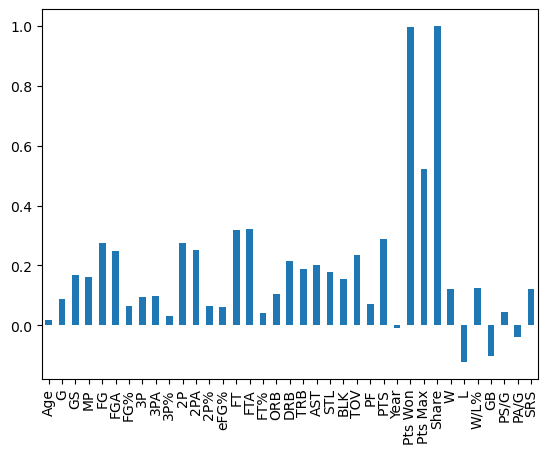

In [13]:
FinalDataSet.corr()["Share"].plot.bar() #reminder - Share is Pts Won(mvp votes) divided by Pts max(max votes available to get)

So by looking at the stats, first of all Pts won and Pts max obviously correlate high to the Share column beacuse they are directly related to how likley you are to win mvp.
The more important correlation we can see is PTS ( points per game) which obviously correaltes high beacuse a player that scores a lot of points is likely to be in the talk for mvp.
Same for GS (game started) that also correlates pretty high.
Some more obvious ones are 2P,AST(assists per game),TRB(Total rebnounds per game),FT(free throws).
What is interesting to see is that TOV correlates pretty high, TOV is turnovers per game which is normally a "bad" thing but it does make a lot of sense beacuse players that lose the ball more, probably also have it more in their hands which means that they are more dominant.
We can also see the W (team wins in a season) has some correaltion beacuse players that lead winning teams are more likely to get more votes, while L ( team losses in a season) has a negative correaltion which also makes a lot of sense beacuse teams that lose more probably have less players that are contending for mvp.

<AxesSubplot:>

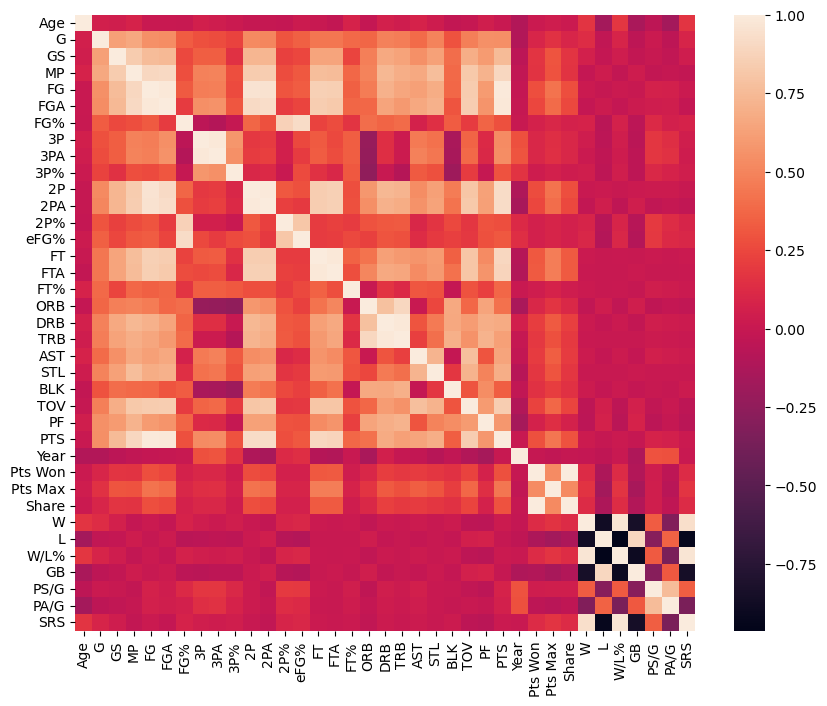

In [45]:
plt.figure(figsize=(10,8))
sns.heatmap(FinalDataSet.corr())

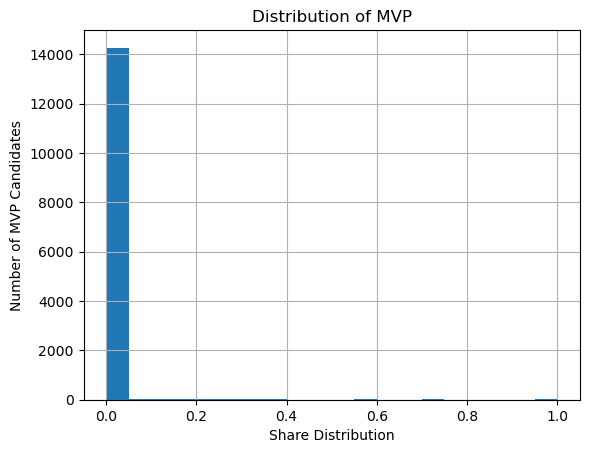

In [28]:
plt.title("Distribution of MVP")
plt.xlabel("Share Distribution")
plt.ylabel("Number of MVP Candidates")
FinalDataSet["Share"].hist(bins=20)
plt.show()

This figure shows how much the MVP shares are spread amongst all candidates in history. What we can see is that the award is very tight and competitive so it's right-skewed. However, there are 2 points near the end of the graph. This outlier is Lebron James' 2013 award when he got almost every single 1st place vote. The other outlier is Stephen Curry's 2016 unanimous MVP season where he got all first-place votes.


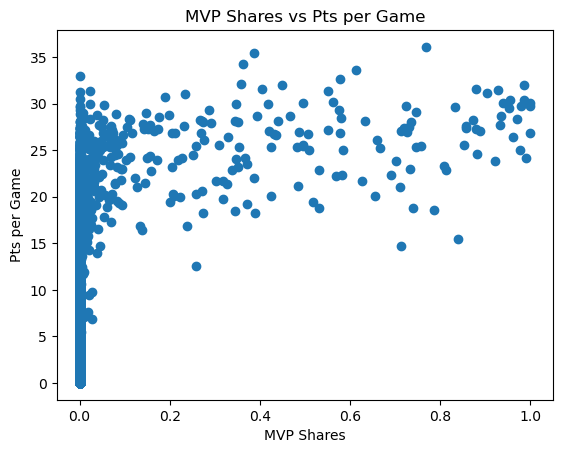

In [33]:
x = FinalDataSet["Share"]
y = FinalDataSet["PTS"]
plt.title("MVP Shares vs Pts per Game")
plt.xlabel("MVP Shares")
plt.ylabel("Pts per Game")
plt.scatter(x,y)
plt.show()

While we can see that players that are getting mvp votes usually have high PTS per game, there are some excpetions and we can we can see that its definetly not the only criteria beacuse we have players that score high but dont get votes, probably beacuse they are a part of losing teams and their points per game dont really mean much.

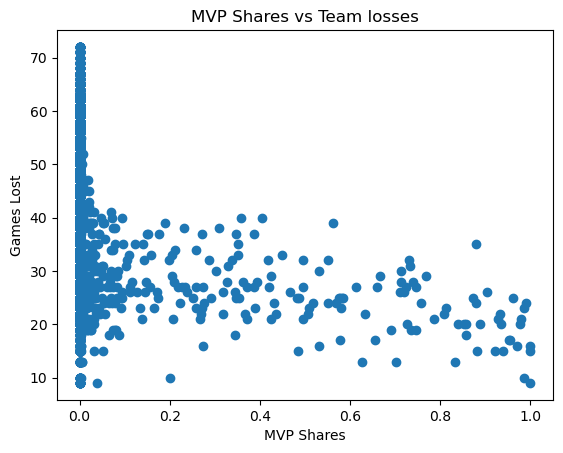

In [34]:
x = FinalDataSet["Share"]
y = FinalDataSet["L"]
plt.title("MVP Shares vs Team losses")
plt.xlabel("MVP Shares")
plt.ylabel("Games Lost")
plt.scatter(x,y)
plt.show()

We can clearley see that players that are a part of a losing team generally wont get any mvp votes and as the number of losses goes down, more players get voted.

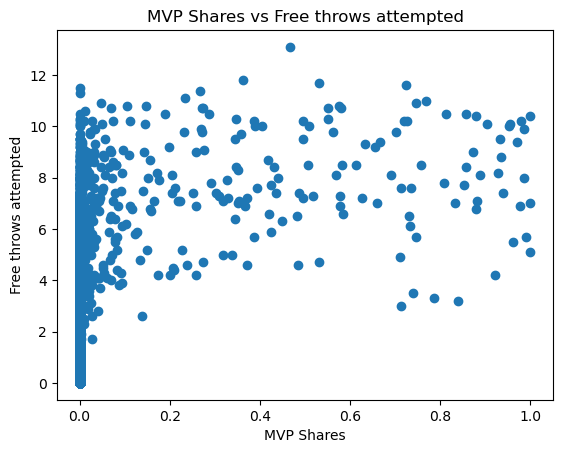

In [42]:
x = FinalDataSet["Share"]
y = FinalDataSet["FTA"]
plt.title("MVP Shares vs Free throws attempted")
plt.xlabel("MVP Shares")
plt.ylabel("Free throws attempted")
plt.scatter(x,y)
plt.show()

Players that attempt more free throws are generally players that are more ball dominant hence why they get fouled more, but we can see by this graph that a dominant player does'nt outright say that this player is definetly an mvp candidate

# Machine Learning

In [47]:
FinalDataSet.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS'],
      dtype='object')

Now we will select the columns that we will use to predict.
We kept only numeric columns and get rid of some useless ones like player name and team names

In [76]:
predictors=[ 'Age',  'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year','W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS']

In [87]:
FinalDataSet=FinalDataSet.dropna()

In [88]:
train = FinalDataSet[~(FinalDataSet["Year"] == 2021)]
test = FinalDataSet[FinalDataSet["Year"] == 2021]

After some research we dicided to use a model called Ridge regression, which is a form of linear regression that is designed to prevent overfitting

In [89]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)

In [90]:
reg.fit(train[predictors],train["Share"])

Ridge(alpha=0.1)

In [99]:
predictions = reg.predict(test[predictors])
predictions = pd.DataFrame(predictions, columns=["predictions"], index=test.index)

In [100]:
combination = pd.concat([test[["Player", "Share"]], predictions], axis=1)

In [102]:
combination.sort_values("Share", ascending=False).head(15)

,Player,Share,predictions
655,Nikola Jokić,0.961,0.158337
8791,Joel Embiid,0.580,0.166185
3707,Stephen Curry,0.449,0.146970
10102,Giannis Antetokounmpo,0.345,0.211716
1403,Chris Paul,0.138,0.073366
11288,Luka Dončić,0.042,0.155504
7613,Damian Lillard,0.038,0.119515
3592,Julius Randle,0.020,0.091378
3587,Derrick Rose,0.010,0.032385
11649,Rudy Gobert,0.008,0.096547


So now we can take a look at this combination dataframe that shows us the actual final mvp race results from the 2021 season with the new predictions column that shows what the algorithem predicted. we can see that Giannis Antetokounmpo was our predicted winner even though he came in 4th in the actual mvp race.
But still we can see that we managed to predict most of the top 15 mvp candidates

## Now we will go into identifying our error metric

In [103]:
from sklearn.metrics import mean_squared_error

mean_squared_error(combination["Share"], combination["predictions"])

0.0027165700568189204

This is the mean difference between the prediction and the actual value, but this isnt really helping us becuase a lot of the actual values is actually 0 and we care only for the players that actually got voted for mvp

In [104]:
combination["Share"].value_counts()

0.000    507
0.001      3
0.961      1
0.138      1
0.010      1
0.020      1
0.449      1
0.005      1
0.038      1
0.003      1
0.580      1
0.345      1
0.042      1
0.008      1
Name: Share, dtype: int64

In [105]:
actual = combination.sort_values("Share", ascending=False)
predicted = combination.sort_values("predictions", ascending=False)
actual["Rk"] = list(range(1,actual.shape[0]+1))
predicted["Predicted_Rk"] = list(range(1,predicted.shape[0]+1))

In [109]:
actual.merge(predicted, on="Player").head(10)

,Player,Share_x,predictions_x,Rk,Share_y,predictions_y,Predicted_Rk
0,Nikola Jokić,0.961,0.158337,1,0.961,0.158337,3
1,Joel Embiid,0.580,0.166185,2,0.580,0.166185,2
2,Stephen Curry,0.449,0.146970,3,0.449,0.146970,6
3,Giannis Antetokounmpo,0.345,0.211716,4,0.345,0.211716,1
4,Chris Paul,0.138,0.073366,5,0.138,0.073366,32
5,Luka Dončić,0.042,0.155504,6,0.042,0.155504,4
6,Damian Lillard,0.038,0.119515,7,0.038,0.119515,11
7,Julius Randle,0.020,0.091378,8,0.020,0.091378,23
8,Derrick Rose,0.010,0.032385,9,0.010,0.032385,77
9,Rudy Gobert,0.008,0.096547,10,0.008,0.096547,18


## The metric we're gonna use is called average precision, its a less common metric that deals with ranking.

In [110]:
def find_ap(combination):
    actual = combination.sort_values("Share", ascending=False).head(5)
    predicted = combination.sort_values("predictions", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index,row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            ps.append(found / seen)
        seen += 1

    return sum(ps) / len(ps)

In [111]:
ap = find_ap(combination)
ap

0.7645833333333333

## Now we are gonna implement backtesting to measure our error for each year, measuring for just one year can be problomatic beacuse that spesific year couldv'e been weird

In [113]:
years = list(range(1990,2022))

In [115]:
aps = []
all_predictions = []
for year in years[5:]:
    train = FinalDataSet[FinalDataSet["Year"] < year]
    test = FinalDataSet[FinalDataSet["Year"] == year]
    reg.fit(train[predictors],train["Share"])
    predictions = reg.predict(test[predictors])
    predictions = pd.DataFrame(predictions, columns=["predictions"], index=test.index)
    combination = pd.concat([test[["Player", "Share"]], predictions], axis=1)
    all_predictions.append(combination)
    aps.append(find_ap(combination))

In [116]:
sum(aps) / len(aps) #This is to calculate our mean average precision

0.7315886152058828

In [117]:
def add_ranks(predictions):
    predictions = predictions.sort_values("predictions", ascending=False)
    predictions["Predicted_Rk"] = list(range(1,predictions.shape[0]+1))
    predictions = predictions.sort_values("Share", ascending=False)
    predictions["Rk"] = list(range(1,predictions.shape[0]+1))
    predictions["Diff"] = (predictions["Rk"] - predictions["Predicted_Rk"])
    return predictions

In [119]:
def backtest(stats, model, years, predictors):
    aps = []
    all_predictions = []
    for year in years:
        train = FinalDataSet[FinalDataSet["Year"] < year]
        test = FinalDataSet[FinalDataSet["Year"] == year]
        model.fit(train[predictors],train["Share"])
        predictions = model.predict(test[predictors])
        predictions = pd.DataFrame(predictions, columns=["predictions"], index=test.index)
        combination = pd.concat([test[["Player", "Share"]], predictions], axis=1)
        combination = add_ranks(combination)
        all_predictions.append(combination)
        aps.append(find_ap(combination))
    return sum(aps) / len(aps), aps, pd.concat(all_predictions)

In [123]:
mean_ap, aps, all_predictions = backtest(FinalDataSet, reg, years[5:], predictors)
print('Linear Ridge regression prediction accuracy %s' % mean_ap)

Linear Ridge regression prediction accuracy 0.7315886152058828


## Now we're gonna try a random forrest model

In [125]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=1, min_samples_split=5)

mean_ap, aps, all_predictions = backtest(FinalDataSet, rf, years[10:], predictors )

In [126]:
print('Linear RandomForestRegressor prediction accuracy %s' % mean_ap)

Linear RandomForestRegressor prediction accuracy 0.732916477735293


# Summary and cunclusion

So we started out by getting 3 different tables of data from the site, the first was the final mvp race for each year, second was the stats per game for every player that played in the league per year and the last was every teams W/L record for every year (all of them were from 1990-2021).
We cleaned our data, filling out missing values and prepearing all the different dataframes for merging to a single big dataframe the held the statistics for every player that has played in the league since 1990, including who got voted for mvp each year and including their team win/loss record.
By looking at the stats and our ML results we can see that predicting the mvp race is hard to do with a high precentege of accuracy, but still we got some nice results and a 73% predictive accuracy for both our models.

## Credits

### We will give credit to the youtube channel Dataquest https://www.youtube.com/@Dataquestio for helping us with how to data crawl from our desired website + using selenium and for learning about the Ridge regression model for machine learning and how to implement it. Some code was taken from their tutorials.